<a href="https://colab.research.google.com/github/JoMihye/Python/blob/main/ml12_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning(앙상블 학습 방법)

*   앙상블(ensemble): 머신 러닝에서 사용되는 일련 모델(알고리즘)들.
    *   서로 다른 모델 여러 개를 학습시키는 방법.
    *   한 가지 모델을 서로 다른 훈련 셋에서 학습시키는 방법.
*   앙상블 학습 방법: 앙상블을 사용한 머신 러닝 방법.
    *   투표(voting) 방식: 여러 개의 모델을 학습시켜서 각각의 예측값을 투표(다수결, 최빈값) 또는 평균값으로 예측하는 방법.
    *   __Bagging(Bootstrap Aggregating)__: _중복을 허용_ 해서 샘플링한 훈련 셋의 부분집합들을 하나의 알고리즘에 학습시켜서 예측(최빈값, 평균)하는 학습 방법.
    *   Pasting: 중복을 허용하지 않고 샘플링한 훈련 셋의 부분집합들을 알고리즘에 학습시켜서 예측하는 방법.
    *   __Boosting__: 약한 학습기를 순차적으로 연결해서 강한 학습기를 만드는 앙상블 학습 방법.
        *   AdaBoost(Adaptive Boosting): 과소적합됐던 훈련 샘플들의 가중치를 높여서 다음 훈련에 순차적으로 사용하는 boosting 방법.
        *   Gradient Boost: 잔여 오차(residual errors)들을 다음 훈련에서 학습시켜서 강한 학습기를 만드는 boosting 방법.
*   __Random Forest__: Bagging을 사용한 Decision Tree들의 ensemble 학습 방법.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC  # SVM(Support Vector Machine) 알고리즘을 사용한 분류기
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier

# Dataset 준비

2개의 특성(x1, x2)과 2개의 클래스(0, 1)를 갖는 가상의 데이터 셋을 생성.

In [ ]:
# X: 특성 배열(features), y: 타겟 배열(target)
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

In [ ]:
X.shape, y.shape

((500, 2), (500,))

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([250, 250]))

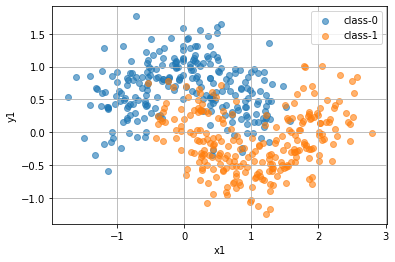

In [ ]:
# X, y를 시각화
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='class-0', alpha=0.6)
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='class-1', alpha=0.6)

plt.legend()
plt.grid()
plt.xlabel('x1')
plt.ylabel('y1')
plt.show()

In [ ]:
# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X, y,
                                          test_size=0.2,
                                          random_state=42,
                                          stratify=y)

# 머신 러닝 모델의 성능 비교

*   5개의 머신 러닝 모델 생성
    *   KNN, Decision Tree, Logistic Regression, SGD, SVM
        *   SGDClassifier의 파라미터 중에서 loss='log'를 사용.
        *   SVC의 파라미터 중에서 probability=True를 사용.
*   5개의 모델을 훈련 셋으로 학습
*   5개 모델의 점수(정확도)를 훈련/테스트 셋에서 계산, 비교.

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)
tree = DecisionTreeClassifier(random_state=42)
logistic = LogisticRegression(random_state=42, n_jobs=-1)
sgd = SGDClassifier(loss='log', random_state=42, n_jobs=-1)
#> loss='log': 각 클래스가 될 확률을 계산해서 예측하기 위해서.
svm = SVC(probability=True, random_state=42)
#> probability=True: 각 클래스가 될 확률을 계산해서 예측하기 위해서.

In [ ]:
classifiers = [knn, tree, logistic, sgd, svm]  # 반복문에서 사용하기 위해서

In [ ]:
knn.__class__.__name__

'KNeighborsClassifier'

In [ ]:
for clf in classifiers:
    clf.fit(X_tr, y_tr)  # 분류기를 훈련 데이터에 학습시킴.
    tr_acc = clf.score(X_tr, y_tr)  # 훈련 셋 정확도
    te_acc = clf.score(X_te, y_te)  # 테스트 셋 정확도
    print(f'{clf.__class__.__name__} - train acc:{tr_acc}, test acc:{te_acc}')

KNeighborsClassifier - train acc:0.93, test acc:0.93
DecisionTreeClassifier - train acc:1.0, test acc:0.84
LogisticRegression - train acc:0.8475, test acc:0.81
SGDClassifier - train acc:0.8425, test acc:0.81
SVC - train acc:0.9275, test acc:0.93


# Voting Ensemble

In [ ]:
vote_clf = VotingClassifier(estimators=[('knn', knn),
                                        ('tree', tree),
                                        ('logistic', logistic),
                                        ('sgd', sgd),
                                        ('svm', svm)],
                            voting='soft',
                            n_jobs=-1)
# estimators: VotingEnsemble을 만들기 위한 ML 모델 ('모델이름', 모델 객체) tuple들의 리스트.
# voting: 투표 방식
#> voting='hard': 기본값. 앙상블의 각 모델들이 동일하게 1표씩 행사. 예측 확률이 필요 없음.
#> voting='soft': 앙상블의 각 모델의 예측값에 예측 확률을 가중치로 곱한 값을 사용해서 최종 결과를 예측.
#> 일반적으로는 soft voting 방식이 더 성능이 좋다고 알려져 있음.

In [ ]:
# voting ensemble을 훈련
vote_clf.fit(X_tr, y_tr)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_jobs=-1)),
                             ('tree', DecisionTreeClassifier(random_state=42)),
                             ('logistic',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('sgd',
                              SGDClassifier(loss='log', n_jobs=-1,
                                            random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 n_jobs=-1, voting='soft')

In [ ]:
# 훈련/테스트 셋 정확도
print('train acc:', vote_clf.score(X_tr, y_tr))
print('test acc:', vote_clf.score(X_te, y_te))

train acc: 0.94
test acc: 0.92


# Bagging Ensemble

In [ ]:
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50,
    max_samples=100,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

BaggingClasifier의 파라미터들:

*   base_estimator: 기본 추정기(예측기). 머신 러닝 모델 객체.
*   n_etimators: 추정기(예측기)의 개수. 기본값 10.
*   max_samples: 훈련 셋의 부분 집합이 가질 수 있는 최대 샘플 개수(정수) 또는 비율(0 ~ 1.0). 기본값은 1.0.
*   bootstrap: True(중복 허용 샘플링, bagging). False(중복 불허 샘플링, pasting). 기본값은 True.
*   oob_score: True(OOB 샘플로 평가 점수 계산). False(OOB 샘플로 평가 점수를 계산하지 않음). 기본값은 False.
    *   OOB(Out-Of-Bagging) 샘플: 중복 허용 샘플링을 하는 동안 한 번도 샘플링되지 못하고 남아 있는 훈련 셋의 샘플.
    *   OOB sample은 validation set 역할을 할 수 있음.

In [ ]:
bagging_clf.fit(X_tr, y_tr)  # 모델 훈련

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=50, n_jobs=-1, oob_score=True,
                  random_state=42)

In [ ]:
bagging_clf.oob_score_  
# OOB(Out-of-bagging) 샘플들로 계산한 점수(정확도)
# OOB score는 일반적으로 테스트 셋 점수보다 약간 좋거나 비슷.

0.91

In [ ]:
print('train acc:', bagging_clf.score(X_tr, y_tr))
print('test acc:', bagging_clf.score(X_te, y_te))

train acc: 0.9425
test acc: 0.9


In [ ]:
# n_esitmators=100, max_samples=1.0 설정해서 교차 검증(cross_validate)
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100, max_samples=1.0, oob_score=True,
    n_jobs=-1, random_state=42
)

In [ ]:
cv = cross_validate(bagging_clf, X_tr, y_tr, n_jobs=-1, return_train_score=True)

In [ ]:
print('train score:', np.mean(cv['train_score']))
print('validation score:', np.mean(cv['test_score']))

train score: 1.0
validation score: 0.9075


# Random Forest

In [ ]:
forest_clf = RandomForestClassifier(n_estimators=50, max_samples=100, oob_score=True,
                                    random_state=42, n_jobs=-1)

In [ ]:
forest_clf.fit(X_tr, y_tr)

RandomForestClassifier(max_samples=100, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=42)

In [ ]:
forest_clf.oob_score_

0.9125

In [ ]:
print('train score:', forest_clf.score(X_tr, y_tr))
print('test score:', forest_clf.score(X_te, y_te))

train score: 0.9475
test score: 0.91


Random Forest: Decision Tree를 사용하는 bagging ensemble 학습 방법.
*   DecisionTree의 파라미터와 Bagging의 파라미터들을 갖음.
*   GridSearchCV, RandomizedSearchCV을 사용해서 tree와 bagging의 하이퍼파라미터들을 튜닝할 수 있음.

# RandomForest를 사용한 wine 분류

# RandomForest를 사용한 breast-cancer 분류